In [2]:
# ─── Cell 1: Install only Gradio & verify existing packages ───────────────────────
# Colab already includes numpy, pandas, matplotlib, pillow, and tensorflow,
# so we only need to install Gradio.
!pip install gradio==3.36.0 --quiet

# Verify versions of all key libraries
import numpy as np, pandas as pd, matplotlib, PIL, tensorflow as tf, gradio
print(f"▶ numpy      {np.__version__}")
print(f"▶ pandas     {pd.__version__}")
print(f"▶ matplotlib {matplotlib.__version__}")
print(f"▶ Pillow     {PIL.__version__}")
print(f"▶ tensorflow {tf.__version__}")
print(f"▶ gradio     {gradio.__version__}")


▶ numpy      2.0.2
▶ pandas     2.2.2
▶ matplotlib 3.10.0
▶ Pillow     11.3.0
▶ tensorflow 2.18.0
▶ gradio     3.36.0


In [3]:
# ─── Cell 2 (UPDATED): Imports, Seeding & Label Names ───────────────────────────
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import gradio as gr
import random
from tensorflow.keras.models import load_model

# Set random seeds for reproducibility
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

# User-friendly class names for FashionMNIST labels 0–9
LABEL_NAMES = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

print(f"▶ Random seed set to {SEED}")
print("▶ Label mapping:", {i: name for i, name in enumerate(LABEL_NAMES)})


▶ Random seed set to 42
▶ Label mapping: {0: 'T-shirt/top', 1: 'Trouser', 2: 'Pullover', 3: 'Dress', 4: 'Coat', 5: 'Sandal', 6: 'Shirt', 7: 'Sneaker', 8: 'Bag', 9: 'Ankle boot'}


In [4]:
# ─── Cell 3: Load Data & Quick Inspect ────────────────────────────────────────────
# Load the CSV files from Colab's local filesystem
train_df = pd.read_csv('fashion-mnist_train.csv')
test_df  = pd.read_csv('fashion-mnist_test.csv')

In [5]:
# 1) Print dataset shapes
print(f"▶ train_df.shape = {train_df.shape}")
print(f"▶ test_df.shape  = {test_df.shape}")


▶ train_df.shape = (60000, 785)
▶ test_df.shape  = (10000, 785)


In [6]:
# 2) Peek at column names and first row
print("▶ train_df columns:", train_df.columns.tolist())
print("▶ train_df first row:\n", train_df.head(1))

▶ train_df columns: ['label', 'pixel1', 'pixel2', 'pixel3', 'pixel4', 'pixel5', 'pixel6', 'pixel7', 'pixel8', 'pixel9', 'pixel10', 'pixel11', 'pixel12', 'pixel13', 'pixel14', 'pixel15', 'pixel16', 'pixel17', 'pixel18', 'pixel19', 'pixel20', 'pixel21', 'pixel22', 'pixel23', 'pixel24', 'pixel25', 'pixel26', 'pixel27', 'pixel28', 'pixel29', 'pixel30', 'pixel31', 'pixel32', 'pixel33', 'pixel34', 'pixel35', 'pixel36', 'pixel37', 'pixel38', 'pixel39', 'pixel40', 'pixel41', 'pixel42', 'pixel43', 'pixel44', 'pixel45', 'pixel46', 'pixel47', 'pixel48', 'pixel49', 'pixel50', 'pixel51', 'pixel52', 'pixel53', 'pixel54', 'pixel55', 'pixel56', 'pixel57', 'pixel58', 'pixel59', 'pixel60', 'pixel61', 'pixel62', 'pixel63', 'pixel64', 'pixel65', 'pixel66', 'pixel67', 'pixel68', 'pixel69', 'pixel70', 'pixel71', 'pixel72', 'pixel73', 'pixel74', 'pixel75', 'pixel76', 'pixel77', 'pixel78', 'pixel79', 'pixel80', 'pixel81', 'pixel82', 'pixel83', 'pixel84', 'pixel85', 'pixel86', 'pixel87', 'pixel88', 'pixel89', 

In [7]:
# 3) Check for any missing values
missing_train = train_df.isnull().sum().sum()
print(f"▶ Missing values in train_df: {missing_train}")

# 4) Label distribution in the training set
label_counts = train_df['label'].value_counts().sort_index()
print("▶ Label distribution:\n", label_counts)

# 5) Pixel intensity range across all pixels
pixel_min = train_df.iloc[:,1:].values.min()
pixel_max = train_df.iloc[:,1:].values.max()
print(f"▶ Pixel value range: [{pixel_min}, {pixel_max}]")


▶ Missing values in train_df: 0
▶ Label distribution:
 label
0    6000
1    6000
2    6000
3    6000
4    6000
5    6000
6    6000
7    6000
8    6000
9    6000
Name: count, dtype: int64
▶ Pixel value range: [0, 255]


/tmp/ipython-input-594164400.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.title(f"Label = {example[0]}")


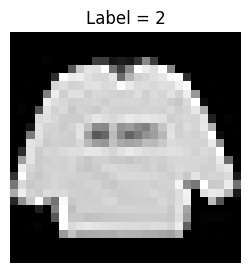

In [8]:
# 6) Visualize one example image
example = train_df.iloc[0]
img_arr  = example.values[1:].astype(np.uint8).reshape(28,28)
plt.figure(figsize=(3,3))
plt.imshow(img_arr, cmap='gray')
plt.title(f"Label = {example[0]}")
plt.axis('off')
plt.show()

In [9]:
# ─── Cell 4: Preprocess & Split ───────────────────────────────────────────────────
# Normalize pixel values to [0,1] and separate features/labels
X        = train_df.iloc[:,1:].values.astype('float32') / 255.0
y        = train_df.iloc[:,0].values.astype('int32')
X_test   = test_df.iloc[:,1:].values.astype('float32') / 255.0
y_test   = test_df.iloc[:,0].values.astype('int32')

# Shuffle the training data
perm = np.random.permutation(len(X))
X, y = X[perm], y[perm]
print(f"▶ First 5 labels after shuffling: {y[:5]}")

# Split into 90% train / 10% validation
split_idx    = int(0.9 * len(X))
X_train, y_train = X[:split_idx], y[:split_idx]
X_val,   y_val   = X[split_idx:], y[split_idx:]
print(f"▶ Split sizes → train: {len(X_train)}, val: {len(X_val)}, test: {len(X_test)}")
# ─── End of Cell 4 ───────────────────────────────────────────────────────────────


▶ First 5 labels after shuffling: [7 8 8 5 9]
▶ Split sizes → train: 54000, val: 6000, test: 10000


In [10]:
# ─── Cell 5: Build & Compile TensorFlow Model ────────────────────────────────────
# Define a simple feed-forward neural network with one hidden layer
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(784,)),      # 28x28 flattened
    tf.keras.layers.Dense(128, activation='relu'),       # Hidden layer
    tf.keras.layers.Dense(10, activation='softmax'),     # Output layer
])

# Compile with Adam optimizer and cross-entropy loss
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Display the model summary
model.summary()
# ─── End of Cell 5 ───────────────────────────────────────────────────────────────


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 101,770 (397.54 KB)

 Trainable params: 101,770 (397.54 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# ─── Cell 6: Train & Plot Curves ──────────────────────────────────────────────────
# Train for 20 epochs with validation
EPOCHS = 20
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=32,
    verbose=2
)


Epoch 1/20
1688/1688 - 7s - 4ms/step - accuracy: 0.8171 - loss: 0.5171 - val_accuracy: 0.8682 - val_loss: 0.3961
Epoch 2/20
1688/1688 - 4s - 2ms/step - accuracy: 0.8588 - loss: 0.3856 - val_accuracy: 0.8735 - val_loss: 0.3633
Epoch 3/20
1688/1688 - 3s - 2ms/step - accuracy: 0.8738 - loss: 0.3446 - val_accuracy: 0.8772 - val_loss: 0.3467
Epoch 4/20
1688/1688 - 3s - 2ms/step - accuracy: 0.8834 - loss: 0.3187 - val_accuracy: 0.8772 - val_loss: 0.3379
Epoch 5/20
1688/1688 - 5s - 3ms/step - accuracy: 0.8909 - loss: 0.2986 - val_accuracy: 0.8863 - val_loss: 0.3207
Epoch 6/20
1688/1688 - 3s - 2ms/step - accuracy: 0.8958 - loss: 0.2825 - val_accuracy: 0.8842 - val_loss: 0.3224
Epoch 7/20
1688/1688 - 5s - 3ms/step - accuracy: 0.9003 - loss: 0.2688 - val_accuracy: 0.8850 - val_loss: 0.3273
Epoch 8/20
1688/1688 - 6s - 3ms/step - accuracy: 0.9045 - loss: 0.2560 - val_accuracy: 0.8878 - val_loss: 0.3248
Epoch 9/20
1688/1688 - 3s - 2ms/step - accuracy: 0.9086 - loss: 0.2464 - val_accuracy: 0.8852 - 

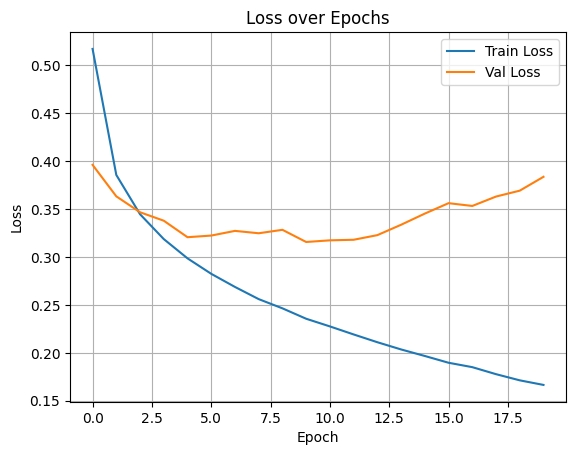

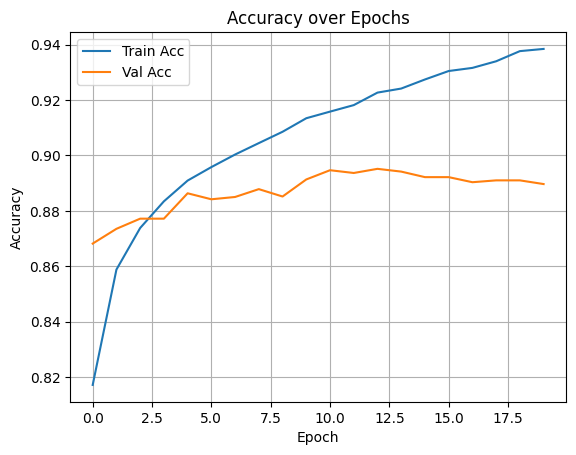

In [12]:
# Plot training & validation loss
plt.figure()
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss over Epochs')
plt.grid(True)
plt.show()

# Plot training & validation accuracy
plt.figure()
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy over Epochs')
plt.grid(True)
plt.show()


In [13]:
# ─── Cell 7 (UPDATED): Evaluate on Test Set & Visualize Samples ─────────────────
# Evaluate final performance on the test set
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss = {test_loss:.4f}, Test Accuracy = {test_acc:.4f}")


Test Loss = 0.3966, Test Accuracy = 0.8821


In [14]:
# ─── Cell 8: Save Trained Model with Proper Extension ──────────────────────
# TensorFlow requires a file extension; use the native Keras format (.keras)
MODEL_PATH = 'fashion_mnist_saved_model.keras'

# Save the model
model.save(MODEL_PATH)

print(f"▶ Model successfully saved to '{MODEL_PATH}'")
# Use: loaded_model = tf.keras.models.load_model(MODEL_PATH) to reload later
# ─── End of Updated Cell ────────────────────────────────────────────────────────


▶ Model successfully saved to 'fashion_mnist_saved_model.keras'


In [15]:
# ─── Cell 9: Load Saved Model for Inference ────────────────────────────────────

# Define path to the saved model directory
MODEL_DIR = 'fashion_mnist_saved_model.keras'

# Load the model
trained_model = load_model(MODEL_DIR)
print(f"▶ Model loaded from '{MODEL_DIR}'")

# (Optional) Verify by showing its architecture
trained_model.summary()
# ─── End of New Cell ─────────────────────────────────────────────────────────────


▶ Model loaded from 'fashion_mnist_saved_model.keras'


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 305,312 (1.16 MB)

 Trainable params: 101,770 (397.54 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 203,542 (795.09 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


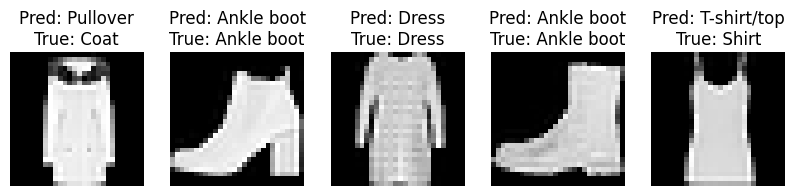

In [16]:
# Visualize 5 random test images with Predicted vs. Actual labels (using names)
idxs = np.random.choice(len(X_test), 5, replace=False)
plt.figure(figsize=(10,2))
for i, idx in enumerate(idxs):
    img = X_test[idx].reshape(28,28)
    pred = np.argmax(trained_model.predict(img.reshape(1,784)), axis=1)[0]
    pred_name = LABEL_NAMES[pred]
    true_name = LABEL_NAMES[y_test[idx]]
    plt.subplot(1,5,i+1)
    plt.imshow(img, cmap='gray')
    plt.title(f"Pred: {pred_name}\nTrue: {true_name}")
    plt.axis('off')
plt.show()